In [1]:
%pip install torch-fidelity

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torchvision
import transformers
import torchmetrics
from tqdm import tqdm

model_dir = '../../Models/ViT-B'
weight_ps = 8
temperature = 0.25

DEVICE = torch.device('cuda:0')

# model checkpoints - should point to checkpoint_final.pth
simmim_model_path = f'{model_dir}/SimMIM/checkpoint_final.pth'
kamim_model_path = f'{model_dir}/KAMIM - {weight_ps} - {temperature}/checkpoint_final.pth'

IMG_NET_PATH = '../Datasets/Imagenet/val/'        # path to imagenet validation set

/home/ml/miniconda3/envs/representation_analysis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
parameters = {
    'batch_size': 2048,
    'model_name': 'ViT-B',
    'dimension' : 192,
    'model_patch_size' : 16,
    'masking_patch_size' :32,
    'mask_ratio': 0.6,
    'num_hidden_layer': 12,
    'num_attention_heads': 12,
    'hidden_size': 768,
    'intermediate_size': 3072, 
    
    'batch_size_finetuning': 2048,
    'batch_size_linear_probe': 2048,
}

In [4]:
DIMENSION = parameters['dimension']                                 # dimension of image
MODEL_PATCH_SIZE = parameters['model_patch_size']                   # patch size         
MASKING_PATCH_SIZE = parameters['masking_patch_size']               # masking patch size
MASK_RATIO = parameters['mask_ratio']                               # model masking ratio
INTERMEDIATE_SIZE = parameters['intermediate_size']
# model config
HIDDEN_SIZE = parameters['hidden_size']
HIDDEN_LAYERS = parameters['num_hidden_layer']
ATTN_HEADS = parameters['num_attention_heads']

config = transformers.ViTConfig(
    hidden_size = HIDDEN_SIZE,
    num_hidden_layers = HIDDEN_LAYERS,
    num_attention_heads= ATTN_HEADS,
    image_size = DIMENSION,
    patch_size = MODEL_PATCH_SIZE,
    intermediate_size= INTERMEDIATE_SIZE,
    num_channels= 3,
)
model_simmim = transformers.ViTForMaskedImageModeling(config)
chkpt = torch.load(simmim_model_path)
if type(chkpt) == dict and 'model_save_dict' in chkpt.keys():
    model_simmim.load_state_dict(chkpt['model_state_dict'])
else:
    model_simmim.load_state_dict(chkpt)
model_simmim = model_simmim.to(DEVICE)

model_kamim = transformers.ViTForMaskedImageModeling(config)
chkpt = torch.load(kamim_model_path)
if type(chkpt) == dict and 'model_save_dict' in chkpt.keys():
    model_kamim.load_state_dict(chkpt['model_state_dict'])
else:
    model_kamim.load_state_dict(chkpt)
model_kamim = model_kamim.to(DEVICE)

# set both to eval
model_simmim.eval()
model_kamim.eval()

ViTForMaskedImageModeling(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [5]:
import numpy as np
from torchvision.transforms import v2

transform = v2.Compose([
                    v2.Normalize(
                        mean = [0.485, 0.456, 0.406],
                        std =  [0.229, 0.224, 0.225]
                    )
                ])

class MaskGenerator:
    def __init__(self, input_size=192, mask_patch_size=32, model_patch_size=4, mask_ratio=0.6):
        self.input_size = input_size
        self.mask_patch_size = mask_patch_size
        self.model_patch_size = model_patch_size
        self.mask_ratio = mask_ratio
        
        assert self.input_size % self.mask_patch_size == 0
        assert self.mask_patch_size % self.model_patch_size == 0
        
        self.rand_size = self.input_size // self.mask_patch_size
        self.scale = self.mask_patch_size // self.model_patch_size
        
        self.token_count = self.rand_size ** 2
        self.mask_count = int(np.ceil(self.token_count * self.mask_ratio))
        
    def __call__(self):
        mask_idx = np.random.permutation(self.token_count)[:self.mask_count]
        mask = np.zeros(self.token_count, dtype=int)
        mask[mask_idx] = 1
        
        mask = mask.reshape((self.rand_size, self.rand_size))
        mask = mask.repeat(self.scale, axis=0).repeat(self.scale, axis=1)
        
        return mask

class ImageNet_Custom(torchvision.datasets.ImageFolder):
    def __init__(self,
                 src,
                 dimension = (192,192),
                 mask_patch_size = 32,
                 model_patch_size = 16,
                 mask_ratio = 0.6):
        super().__init__(src)
        self.mask_gen = MaskGenerator(input_size = dimension[0],
                                      mask_patch_size = mask_patch_size,
                                      model_patch_size = model_patch_size,
                                      mask_ratio = mask_ratio
                                      )
        self.transform = v2.Compose([
                            v2.ToImage(), 
                            v2.ToDtype(torch.uint8, scale=True),
                            v2.Compose([
                                v2.Resize((192, 192), antialias = False),
                                v2.ToDtype(torch.float32, scale=True)
                                ]),
                            ])

    def __getitem__(self, idx):
        img, _ = super().__getitem__(idx)        
        mask = self.mask_gen()
        img = self.transform(img)
        
        return img, mask

In [6]:
imgnet_train = ImageNet_Custom(
    src = IMG_NET_PATH,
    dimension = (192,192),
    mask_patch_size = 32,
    model_patch_size = 16,
    mask_ratio = 0.4
)

In [7]:
dataloader = torch.utils.data.DataLoader(
    imgnet_train,
    batch_size = 512,
    shuffle = False,
    num_workers = 12,
    pin_memory = True,
    persistent_workers = True,
)

## Visualizing reconstructed images

In [8]:
import random

torch.backends.cudnn.deterministic = True
random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
np.random.seed(1)

dataloader_shuffle = torch.utils.data.DataLoader(
    imgnet_train,
    batch_size = 512,
    shuffle = True,
    num_workers = 12,
    pin_memory = True,
    persistent_workers = True,
)

# for reconstructed images
_, data = next(enumerate(dataloader_shuffle))
plain_img, mask = data

img = transform(plain_img).to(DEVICE)
mask = mask.to(DEVICE)

with torch.no_grad():
    reproduc_simmim = model_simmim(img, bool_masked_pos=mask.flatten(1))['reconstruction']
    reproduc_kamim = model_kamim(img, bool_masked_pos=mask.flatten(1))['reconstruction']
    
w_img =  (
    mask.repeat_interleave(16, 1)
    .repeat_interleave(16, 2)
    .unsqueeze(1)
    .contiguous()
    ).cpu()

masked_image = w_img.cpu() * plain_img.cpu()

In [9]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
    
unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0049874187..0.97131085].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.028091997..0.9487686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0049913526..0.60386837].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.008349776..0.565204].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.01808083..1.0602831].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0058612227..1.0728979].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got r

5
30
55
80
105


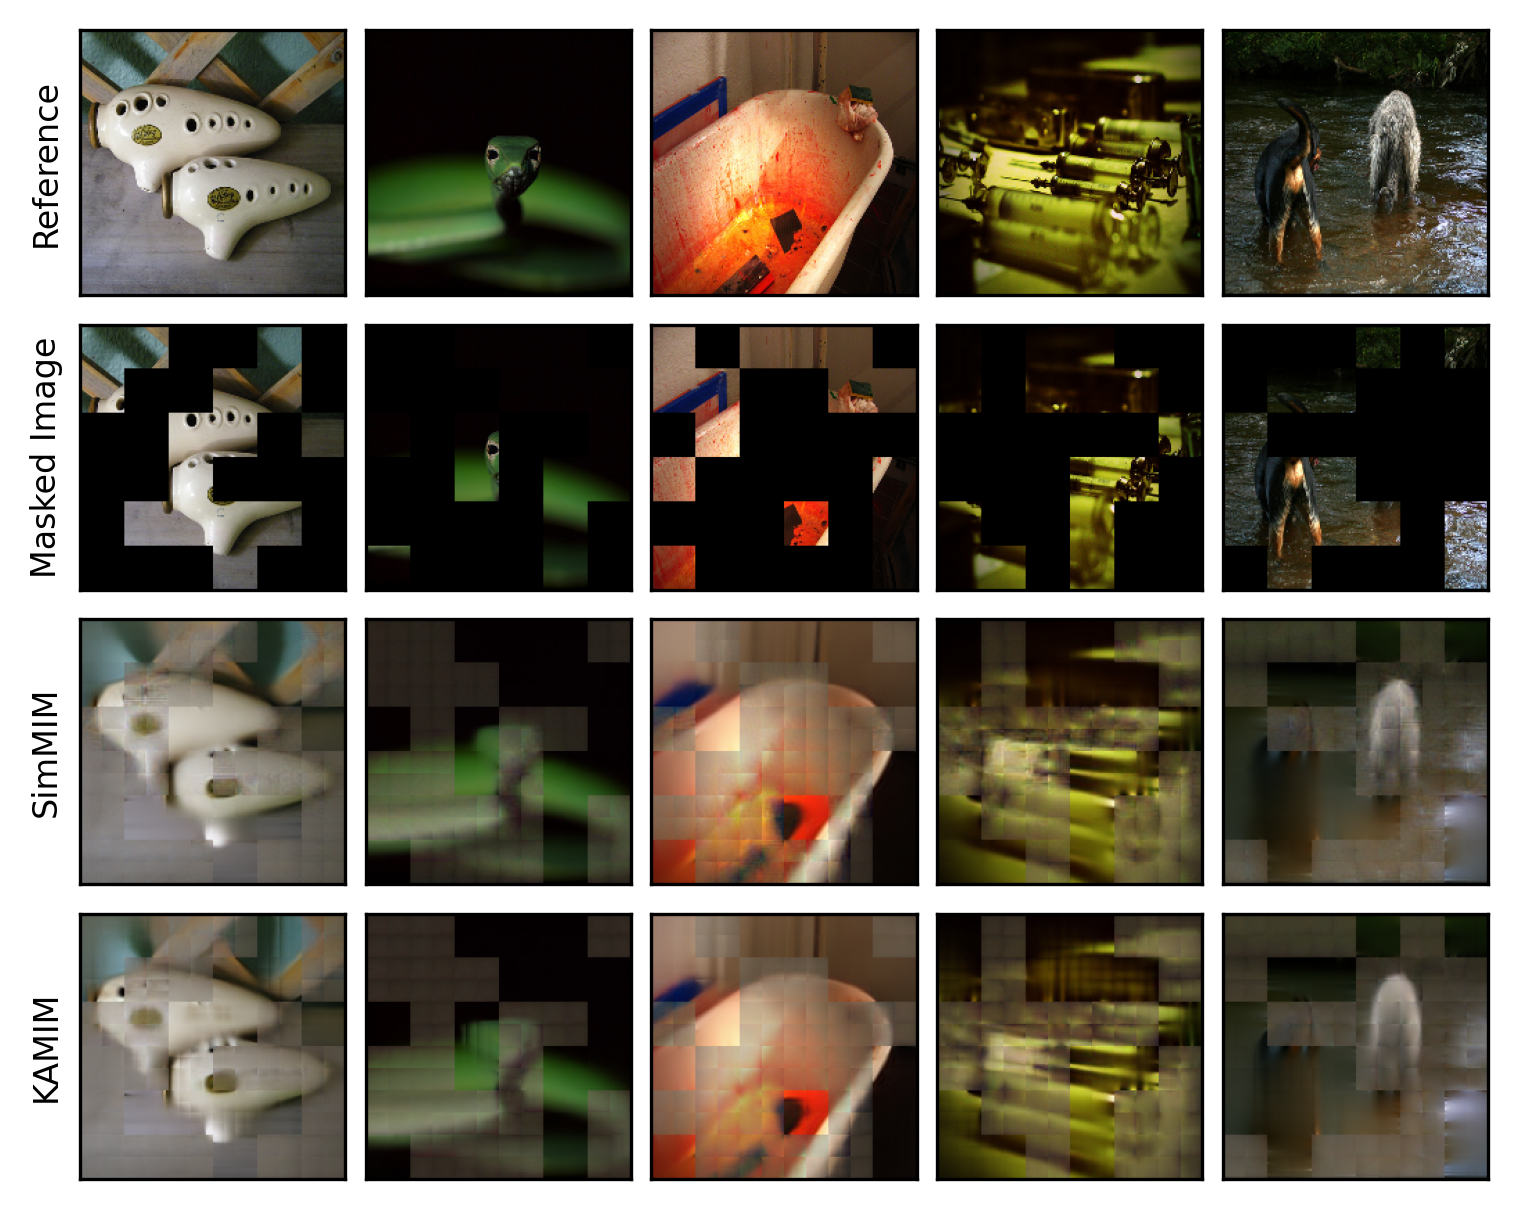

In [10]:
import matplotlib.pyplot as plt

si = 5
step = 25

max_imgs = 5
fig, ax = plt.subplots(4, max_imgs, figsize = (5,4), dpi = 300)

for i in range(max_imgs):
    print(si+step*i)
    ax[0][i].imshow(plain_img[si+step*i].permute(1,2,0).cpu())
    ax[1][i].imshow(masked_image[si+step*i].permute(1,2,0).cpu())
    ax[2][i].imshow(unorm(reproduc_simmim[si+step*i]).permute(1,2,0).cpu())
    ax[3][i].imshow(unorm(reproduc_kamim[si+step*i]).permute(1,2,0).cpu())

ax[0][0].set_ylabel("Reference", size = 8)
ax[1][0].set_ylabel("Masked Image", size = 8)
ax[2][0].set_ylabel("SimMIM", size = 8)
ax[3][0].set_ylabel("KAMIM", size = 8)



for a in ax:
    for _ in a:
        _.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False)
        _.xaxis.set_ticklabels([])
        _.yaxis.set_ticklabels([])
        _.set_axis_on()
        
fig.tight_layout(pad = 0.5)
fig.savefig("reconstruction.pdf", facecolor = 'white')

## Fidelity metrics

In [ ]:
# init psnr
psnr_simmim = torchmetrics.image.PeakSignalNoiseRatio().to(DEVICE)
psnr_kamim = torchmetrics.image.PeakSignalNoiseRatio().to(DEVICE)

# init ssim
ssim_simmim = torchmetrics.image.StructuralSimilarityIndexMeasure().to(DEVICE)
ssim_kamim = torchmetrics.image.StructuralSimilarityIndexMeasure().to(DEVICE)

# # init FID
# fid_simmim = torchmetrics.image.fid.FrechetInceptionDistance().to(DEVICE)
# fid_kamim = torchmetrics.image.fid.FrechetInceptionDistance().to(DEVICE)

# init LPI
lpi_simmim = torchmetrics.image.lpip.LearnedPerceptualImagePatchSimilarity(normalize = True).to(DEVICE)
lpi_kamim = torchmetrics.image.lpip.LearnedPerceptualImagePatchSimilarity(normalize = True).to(DEVICE)

for data in tqdm(dataloader):
    img, mask = data
    img = transform(img)
    
    img = img.to(DEVICE)
    mask = mask.to(DEVICE)
    
    with torch.no_grad():
        reproduc_simmim = model_simmim(img, bool_masked_pos=mask.flatten(1))['reconstruction']
        reproduc_kamim = model_kamim(img, bool_masked_pos=mask.flatten(1))['reconstruction']

        # update_psnr
        psnr_simmim(reproduc_simmim, img)
        psnr_kamim(reproduc_kamim, img)
        
        # update ssim
        ssim_simmim(reproduc_simmim, img)
        ssim_kamim(reproduc_kamim, img)
        
        # # update fid
        # update_imgs_simmim = torch.vstack([img,
        #                                    reproduc_simmim]).to(DEVICE)
        # update_imgs_kamim = torch.vstack([img,
        #                                    reproduc_kamim]).to(DEVICE)
        # update_labs = torch.vstack([torch.ones(len(img)),
        #                             torch.zeros(len(img))]).bool().to(DEVICE)
        
        # fid_simmim(update_imgs_simmim, update_labs)       # update real dist for simmim
        # fid_simmim(update_imgs_kamim, update_labs)      # update real dist for kamim
        
        # update lpi
        lpi_simmim(torch.nn.functional.sigmoid(reproduc_simmim), torch.nn.functional.sigmoid(img))
        lpi_simmim(torch.nn.functional.sigmoid(reproduc_kamim), torch.nn.functional.sigmoid(img))

on training set

- SimMIM PSNR: 12.082398414611816
- SimMIM SSIM: 0.11498011648654938
- SimMIM LPI: 0.8361510634422302
- KAMIM PSNR: 12.088289260864258
- KAMIM SSIM: 0.11290539056062698
- KAMIM LPI: nan

on testing set

- SimMIM PSNR: 12.058865547180176
- SimMIM SSIM: 0.10958657413721085
- SimMIM LPI: 0.84823077917099
- KAMIM PSNR: 12.063213348388672
- KAMIM SSIM: 0.10762996971607208
- KAMIM LPI: nan

In [ ]:
print(f"SimMIM PSNR: {psnr_simmim.compute()}")
print(f"SimMIM SSIM: {ssim_simmim.compute()}")
print(f"SimMIM LPI: {lpi_simmim.compute()}")

print(f"KAMIM PSNR: {psnr_kamim.compute()}")
print(f"KAMIM SSIM: {ssim_kamim.compute()}")
print(f"KAMIM LPI: {lpi_kamim.compute()}")